In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy as sa
import seaborn as sns
import sqlalchemy.types
from datetime import timedelta
import matplotlib.pyplot as plt
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from sqlalchemy.engine import reflection

connection_string = 'DRIVER={ODBC Driver 17 for sql server};SERVER=BI-SQL;DATABASE=ZSDBillingDoc_BillingItm;UID=sa;PWD=1qazXSW@'

connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

engine = create_engine(connection_url,pool_size=10, max_overflow=20)

 
with engine.begin() as conn:
    df = pd.read_sql_query(sa.text('SELECT [BILLDOC],[BILLTOPARTY],[DOCDATE],SUM([Calc_NETAMOUNT_Absolute_Final]) as SalesAmount FROM [ZSDBillingDoc_BillingItm].[dbo].[/BIC/OHZSDBILMHB] GROUP BY [BILLDOC] ,[BILLTOPARTY],[DOCDATE]'), conn)

df.to_csv('RFM-Data')    
conn.close()

In [2]:
df=pd.read_csv(r'C:\Users\b-jafari.ZARMACARON\Notebooks\Marketing Data Analysis\RFM-Data')

In [3]:
df=df.drop('Unnamed: 0',axis=1)


In [4]:
df['DOCDATE'] = pd.to_datetime(df['DOCDATE'].astype(str), format='%Y%m%d')

In [5]:
df[['BILLDOC','BILLTOPARTY']]=df[['BILLDOC','BILLTOPARTY']].astype('category')

In [6]:
#df['DOCDATE'] = pd.to_datetime(df['DOCDATE'], errors='coerce')

In [7]:
df=df[df['DOCDATE'] != '1762-03-13']

In [8]:
pd.set_option('display.float_format','{:}'.format)

In [9]:
maxdate=df.DOCDATE.max()+timedelta(days=1)

In [10]:
dt=df.groupby('BILLTOPARTY').agg({
    'SalesAmount' : lambda x : x.sum() , 
    'DOCDATE' :lambda x: (maxdate- x.max()).days,
    'BILLDOC' : lambda x : x.nunique()
}).reset_index()



In [11]:
dt.rename(columns={'SalesAmount': 'Monetary', 'DOCDATE': 'Recency', 'BILLDOC': 'Frequency'}, inplace=True)


In [12]:
dt['MNFR']=dt['Monetary']*dt['Frequency']

In [13]:
Quantiles=dt.quantile([0.2, 0.4, 0.6, 0.8])
Quantiles=Quantiles.to_dict()

C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_118356\3777026450.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Quantiles=dt.quantile([0.2, 0.4, 0.6, 0.8])


In [14]:
def RFM(x,VAR):
    if VAR == 'Recency':
        if    x <= Quantiles[VAR][0.2] :
            return 5
        elif  x <= Quantiles[VAR][0.4] :
            return 4
        elif  x <= Quantiles[VAR][0.6]  :
            return 3
        elif  x <= Quantiles[VAR][0.8] :
            return 2
        else :
            return 1;
    
    if VAR in ('Monetary' , 'Frequency' , 'MNFR'):
        if    x <= Quantiles[VAR][0.2] :  
            return 1
        if    x <= Quantiles[VAR][0.4] :
            return 2
        elif  x <= Quantiles[VAR][0.6]  :
            return 3
        elif  x <= Quantiles[VAR][0.8] :
            return 4
        else :
            return 5
        
        


In [15]:
dt['R']=dt['Recency'].apply({lambda x : RFM(x,'Recency')})
dt['F']=dt['Frequency'].apply({lambda x : RFM(x,'Frequency')})
dt['M']=dt['Monetary'].apply({lambda x : RFM(x,'Monetary')})
dt['MF']=dt['MNFR'].apply({lambda x: RFM(x,'MNFR')})

dt['R'] = dt['Recency'].apply(
    lambda x: 4 if x <= Quantiles['Recency'][0.25] else 
              3 if x <= Quantiles['Recency'][0.5] else 
              2 if x <= Quantiles['Recency'][0.75] else 1
)

dt['F'] = dt['Frequency'].apply(
    lambda x: 1 if x <= Quantiles['Frequency'][0.25] else 
              2 if x <= Quantiles['Frequency'][0.5] else 
              3 if x <= Quantiles['Frequency'][0.75] else 4
)

dt['M'] = dt['Monetary'].apply(
    lambda x: 1 if x <= Quantiles['Monetary'][0.25] else 
              2 if x <= Quantiles['Monetary'][0.5] else 
              3 if x <= Quantiles['Monetary'][0.75] else 4
)

dt['Score'] = dt['R'] + dt['F'] + dt['M']


In [16]:
def apply_condition(Recency , monetary_frequency):
    if Recency  == 5 and monetary_frequency >= 4:
        return "Champions"
    elif Recency  >= 3 and monetary_frequency >= 4:
        return "Loyal Customers"
    elif Recency  >= 4 and monetary_frequency >= 2:
        return "Potential Loyalists"
    elif Recency  == 5 and monetary_frequency == 1:
        return "New Customers"
    elif Recency  == 4 and monetary_frequency == 1:
        return "Promising"
    elif Recency  == 3 and monetary_frequency == 3:
        return "About to Sleep"
    elif Recency  == 3 and monetary_frequency <= 2:
        return "Need Attention"
    elif Recency  <= 2 and monetary_frequency == 5:
        return "Can't Lose Them"
    elif Recency  <= 2 and monetary_frequency >= 3:
        return "At Risk"
    elif Recency  <= 2 and monetary_frequency <= 2:
        return "Hibernating"
    else:
        return "Error"

In [17]:
dt['Score']= dt['R']+dt['F']+dt['M']

In [18]:
dt["rfm_segment"] = dt.apply(lambda row: apply_condition(row["R"], row["MF"]),axis=1)

In [25]:
rfm=dt.groupby(['rfm_segment'])['BILLTOPARTY'].count().reset_index()

In [27]:
rfm.rename(columns={'BILLTOPARTY':'Customers'},inplace=True)

In [28]:
rfm=rfm.sort_values('Customers',ascending=False)

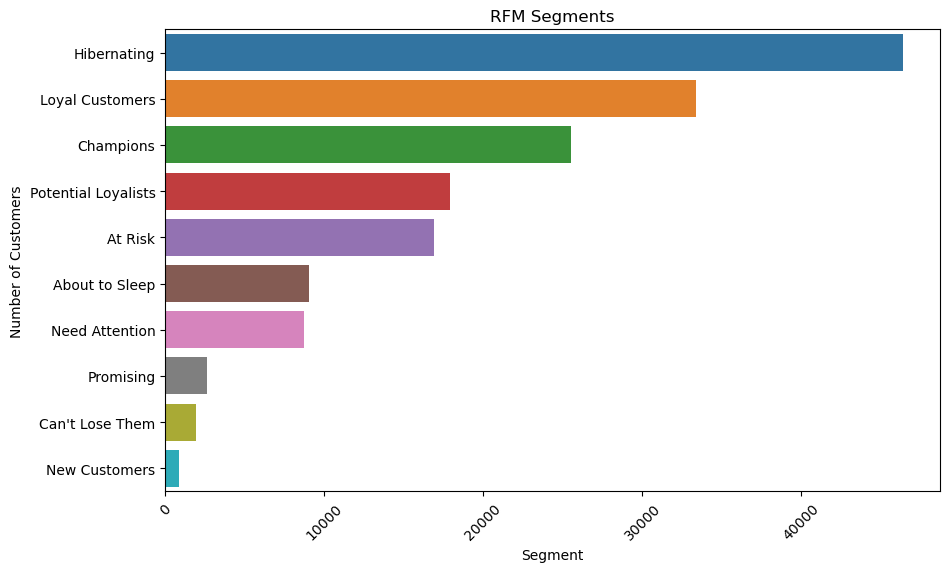

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Customers',y='rfm_segment',  data=rfm, order=rfm['rfm_segment'])
plt.title('RFM Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()